<a href="https://colab.research.google.com/github/colingwuyu/hedgingbox/blob/develop/examples/qtable/qtable_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install necessary dependencies.
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]


In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#@title Update HedgingBox
import os
project_folder = '/content/Projects'
hb_source = os.path.join(project_folder, 'HedgingBox')
%mkdir "$project_folder"
%cd "$project_folder"
!pwd
!mkdir -p 'ACME Models/QTable'
!git clone https://github.com/colingwuyu/HedgingBox.git
%cd HedgingBox
!git fetch --all
!git checkout -b develop origin/develop 
!git pull
import sys
sys.path.append(hb_source)

In [ ]:
#@title Import Modules
import acme
import dm_env
from acme import specs
from acme import datasets
from acme import wrappers
from acme.utils.loggers.csv import CSVLogger
from acme.adders import reverb as adders

import reverb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hb
from hb.market_env import hedging_market_env
from hb.market_env.pathgenerators import gbm_pathgenerator
from hb.market_env.rewardrules.pnl_reward import PnLReward
from hb.market_env.rewardrules.pnl_sqrpenalty_reward import PnLSquarePenaltyReward
from hb.market_env import market_specs
from hb.bots.qtablebot.bot import QTableBot
from hb.bots.qtablebot.actor import QTableActor
from hb.bots.qtablebot.learning import QTableLearner
from hb.bots.qtablebot.qtable import QTable
from hb.bots.deltabot.bot import DeltaHedgeBot

Build Environment

In [ ]:
#@title Default title text
trading_cost_pct =  0.05#@param {type:"number"}
kappa = 0.08 #@param {type:"number"}
initial_price =  50#@param {type:"number"}
drift = 0.0 #@param {type:"number"}
sigma = 0.15 #@param {type:"number"}
number_steps =  3#@param {type:"integer"}
stock_price_lower_bound = 1 #@param {type:"integer"}
stock_price_upper_bound = 10000 #@param {type:"integer"}
lot_size = 1 #@param {type:"integer"}
stock_ticker_size = 1 #@param {type:"integer"}
option_holding =  -10#@param {type:"integer"}
initial_stock_holding =  2#@param {type:"integer"}
buy_sell_lots_bound =  4#@param {type:"integer"}
gbm = gbm_pathgenerator.GBMGenerator(
            initial_price=initial_price, drift=drift,
            div=0.0, sigma=sigma, num_step=number_steps, 
            step_size=30./360., seed=1234
        )
gbm_pred = gbm_pathgenerator.GBMGenerator(
            initial_price=initial_price, drift=drift,
            div=0.0, sigma=sigma, num_step=number_steps, 
            step_size=30./360., seed=4321
        )
pnl_penalty_reward = PnLSquarePenaltyReward(scale_k=kappa)
pnl_reward = PnLReward()
market_param = market_specs.MarketEnvParam(
    stock_ticker_size=stock_ticker_size,
    stock_price_lower_bound=stock_price_lower_bound,
    stock_price_upper_bound=stock_price_upper_bound,
    lot_size=lot_size,
    buy_sell_lots_bound=buy_sell_lots_bound,
    holding_lots_bound=np.infty)
environment = wrappers.SinglePrecisionWrapper(hedging_market_env.HedgingMarketEnv(
            stock_generator=gbm,
            reward_rule=pnl_penalty_reward,
            market_param=market_param,
            trading_cost_pct=trading_cost_pct,
            risk_free_rate=0.,
            discount_rate=0.,
            option_maturity=450./360.,
            option_strike=initial_price,
            option_holding=option_holding,
            initial_stock_holding=initial_stock_holding,
        ))


In [ ]:
#@title Create QTable Hedging Bot
#@markdown ###Replay Buffer Param
batch_size =  1#@param {type:"integer"}
samples_per_insert =  1#@param {type:"integer"}
min_replay_size =  1#@param {type:"integer"}
max_replay_size =  3#@param {type:"integer"}
#@markdown ###Prediction Param
num_prediction_episodes = 1000 #@param {type:"integer"}
train_episodes_per_pred = 5000 #@param {type:"integer"}
model_name = "5pcttradingcost_kappa8_init2holding" #@param {type:"string"}
model_path = f"/content/gdrive/My Drive/Projects/ACME Models/QTable/{model_name}/"
if not os.path.exists(model_path):
  os.makedirs(model_path)
  
qtable_bot_env_attr = ['remaining_time', 'stock_holding', 'stock_price']
environment.set_obs_attr(qtable_bot_env_attr)
spec = specs.make_environment_spec(environment)
pred_logger = CSVLogger(f'qtable_pred/{model_name}',
                        label='qtable_pred')
qtable_bot = QTableBot(environment_spec=spec,
                       epsilon=0.8,
                       batch_size=batch_size,
                       samples_per_insert=samples_per_insert, 
                       min_replay_size=min_replay_size,
                       max_replay_size=max_replay_size,
                       pred_episode = num_prediction_episodes,
                       pred_logger = pred_logger,
                       observation_per_pred = train_episodes_per_pred)

In [ ]:
 #@title Train QTable
qtable_bot._actor._actor._adder.reset()
environment.set_obs_attr(qtable_bot_env_attr)
num_episodes =  train_episodes_per_pred + num_prediction_episodes
epsilon = 0.8 #@param {type:"number"}
num_check_points =  60#@param {type:"integer"}
learning_rate = 1e-3 #@param {type:"number"}
repeat_path =  None#@param {type:"integer"}
start_new_model = False #@param {type:"boolean"}
environment.set_repeat_path(repeat_path)
model_location = f'{model_path}qtable.pickle'
# model_location = f'/content/gdrive/My\ Drive/Projects/ACME\ Models/QTable/{model_name}_qtable.pickle'
if os.path.exists(model_location) and (not start_new_model):
  qtable_bot.restore(model_location)
qtable_bot._actor._epsilon = epsilon
qtable_bot._learner._learning_rate = learning_rate
# Try running the environment loop. We have no assertions here because all
# we care about is that the agent runs without raising any errors.
if num_episodes > 0:
  for i in range(num_check_points):
    print(f"Check Point {i}")
    # train
    environment.set_stock_generator(gbm)
    loop = acme.EnvironmentLoop(environment, qtable_bot)
    loop.run(num_episodes=train_episodes_per_pred)
    # prediction
    gbm_pred.restart()
    environment.set_stock_generator(gbm_pred)
    loop.run(num_episodes=num_prediction_episodes)
    # save model
    qtable_bot.save(model_location)

Streaming output truncated to the last 5000 lines.
[Learner] Action = -4.000 | Avg Td Error = -36.960 | Q = -0.455 | Reward = -37.403 | State = 420|1|52 | Steps = 39711 | Walltime = 114.539
[Environment Loop] Episode Length = 3 | Episode Return = -23.276 | Episodes = 3245 | Steps = 9735 | Steps Per Second = 378.581
[Learner] Action = 0.000 | Avg Td Error = 6.788 | Q = -2.170 | Reward = 4.762 | State = 450|2|50 | Steps = 40081 | Walltime = 115.540
[Environment Loop] Episode Length = 3 | Episode Return = 5.473 | Episodes = 3367 | Steps = 10101 | Steps Per Second = 193.010
[Learner] Action = 0.000 | Avg Td Error = 5.964 | Q = -2.120 | Reward = 3.958 | State = 450|2|50 | Steps = 40433 | Walltime = 116.541
[Environment Loop] Episode Length = 3 | Episode Return = -1.451 | Episodes = 3487 | Steps = 10461 | Steps Per Second = 381.925
[Learner] Action = 0.000 | Avg Td Error = -47.747 | Q = -0.059 | Reward = -47.806 | State = 390|0|50 | Steps = 40801 | Walltime = 117.543
[Environment Loop] Episo

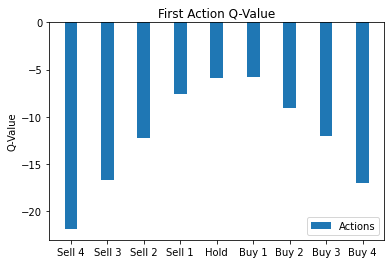

In [ ]:
firstaction_q = qtable_bot._learner._qtable._qtable['450|2|50']
labels = ['Sell 4', 'Sell 3', 'Sell 2', 'Sell 1', 'Hold', 'Buy 1', 'Buy 2', 'Buy 3', 'Buy 4']
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
fah = ax.bar(x, firstaction_q, width, label='Actions')

ax.set_ylabel('Q-Value')
ax.set_title('First Action Q-Value')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()
plt.savefig(f'{model_path}firstaction.png')
plt.show()

In [ ]:
#@title Create Delta Hedging Bot and Set Env State Space
delta_bot_env_attr = ['remaining_time', 'option_holding', 'option_strike',
                      'interest_rate', 'stock_price', 'stock_dividend',
                      'stock_sigma', 'stock_holding']
environment.set_obs_attr(delta_bot_env_attr)
gbm_pred.restart()
environment.set_stock_generator(gbm_pred)
spec = specs.make_environment_spec(environment)
delta_pred_logger = CSVLogger(f'delta_pred/{model_name}',
                              label='delta_pred')
if os.path.exists(delta_pred_logger.file_path):
  os.remove(delta_pred_logger.file_path)
delta_bot = DeltaHedgeBot(environment_spec=spec,
                          pred_episode=num_prediction_episodes,
                          logger = delta_pred_logger)
loop = acme.EnvironmentLoop(environment, delta_bot)
loop.run(num_episodes=num_prediction_episodes)

[Environment Loop] Episode Length = 3 | Episode Return = -21.882 | Episodes = 575 | Steps = 1725 | Steps Per Second = 1769.251


In [ ]:
train_progress = pd.read_csv(pred_logger.file_path)
delta_hedge_status = pd.read_csv(delta_pred_logger.file_path)

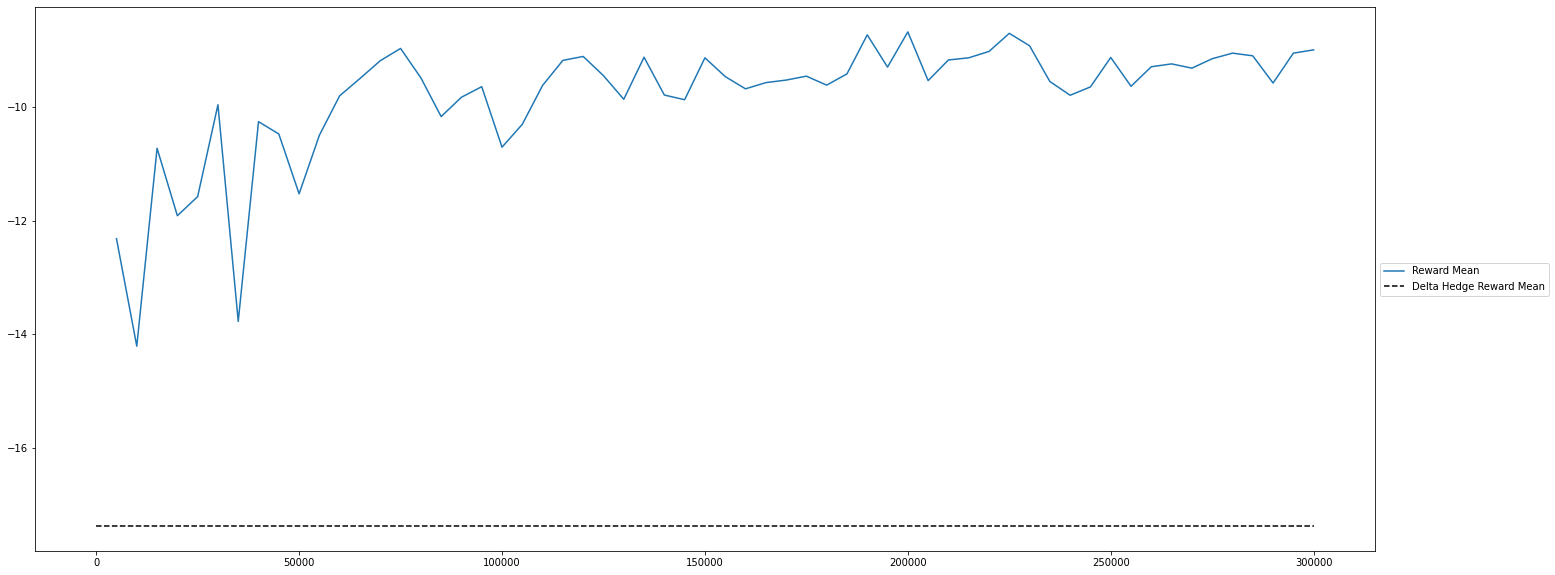

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)
ax.plot(train_progress['train_episodes'], train_progress['reward_mean'], label='Reward Mean')
ax.hlines(delta_hedge_status['reward_mean'], label='Delta Hedge Reward Mean', xmin=0, 
          xmax=train_progress['train_episodes'].max(), linestyles='dashed')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{model_path}reward.png')
plt.show()

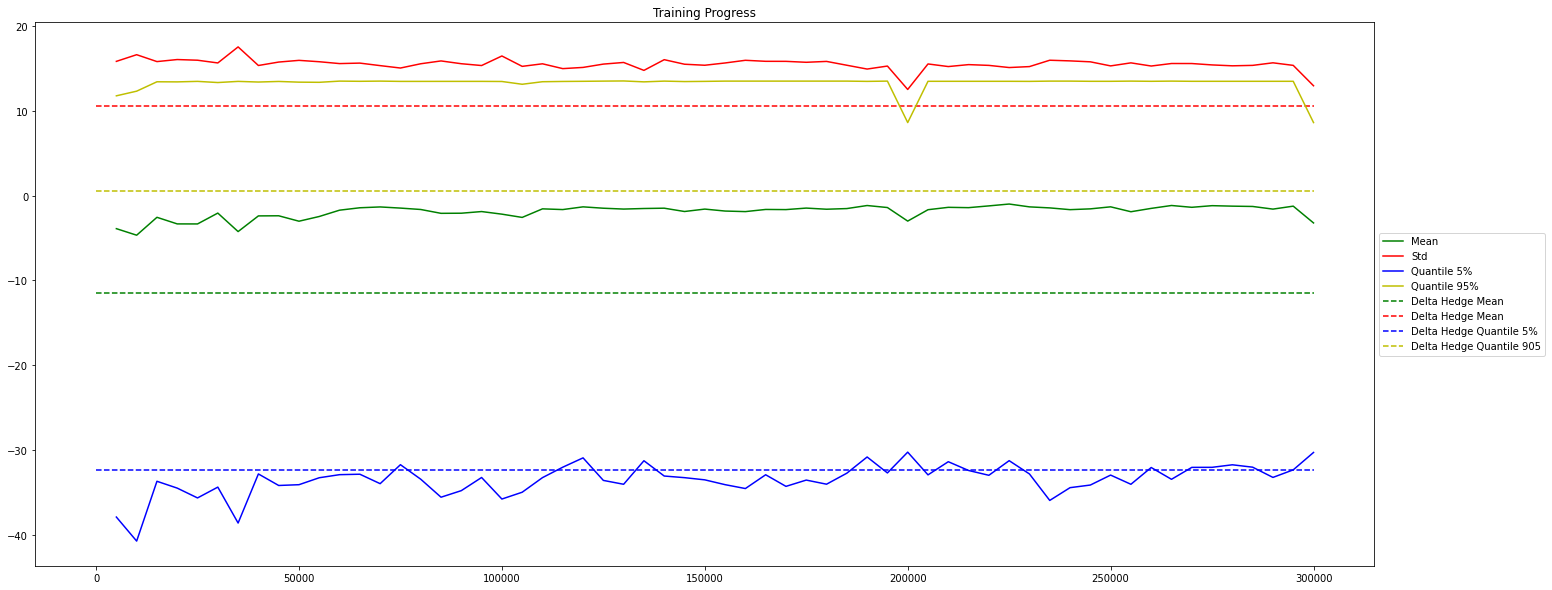

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)

pred_count = train_progress['train_episodes']
ax.plot(pred_count, train_progress['pnl_mean'], label='Mean', color='g')
ax.plot(pred_count, train_progress['pnl_std'], label='Std', color='r')
ax.plot(pred_count, train_progress['pnl_quantile_5'], label='Quantile 5%', color='b')
ax.plot(pred_count, train_progress['pnl_quantile_95'], label='Quantile 95%', color='y')
ax.hlines(delta_hedge_status['pnl_mean'], label='Delta Hedge Mean', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='g')
ax.hlines(delta_hedge_status['pnl_std'], label='Delta Hedge Mean', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='r')
ax.hlines(delta_hedge_status['pnl_quantile_5'], label='Delta Hedge Quantile 5%', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='b')
ax.hlines(delta_hedge_status['pnl_quantile_95'], label='Delta Hedge Quantile 905', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors='y')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Training Progress')
plt.savefig(f'{model_path}quantiles.png')
plt.show()

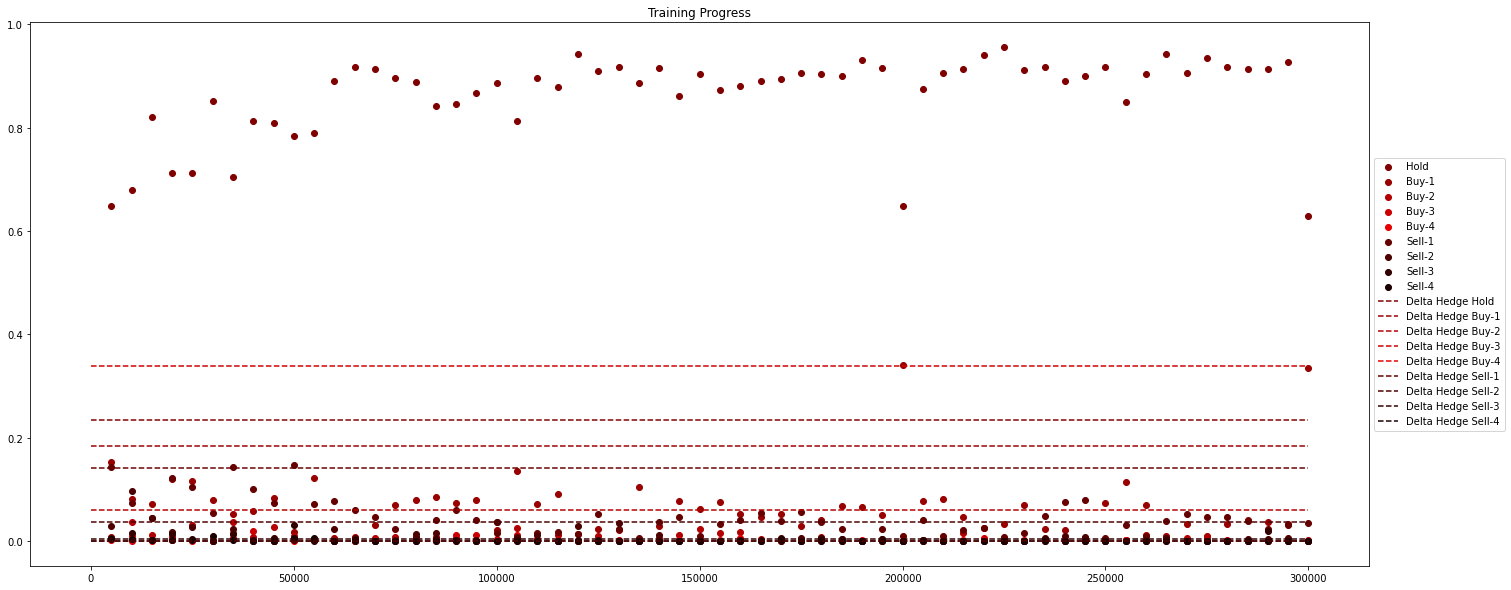

In [ ]:
fig = plt.figure(figsize=(30,10))
ax = plt.subplot(111)

pred_count = train_progress['train_episodes']
ax.scatter(pred_count, train_progress['hold'], label='Hold', color=(0.5,0,0))
ax.scatter(pred_count, train_progress['buy-1'], label='Buy-1', color=(0.6,0,0))
ax.scatter(pred_count, train_progress['buy-2'], label='Buy-2', color=(0.7,0,0))
ax.scatter(pred_count, train_progress['buy-3'], label='Buy-3', color=(0.8,0,0))
ax.scatter(pred_count, train_progress['buy-4'], label='Buy-4', color=(0.9,0,0))
ax.scatter(pred_count, train_progress['sell-1'], label='Sell-1', color=(0.4,0,0))
ax.scatter(pred_count, train_progress['sell-2'], label='Sell-2', color=(0.3,0,0))
ax.scatter(pred_count, train_progress['sell-3'], label='Sell-3', color=(0.2,0,0))
ax.scatter(pred_count, train_progress['sell-4'], label='Sell-4', color=(0.1,0,0))
ax.hlines(delta_hedge_status['hold'], label='Delta Hedge Hold', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.5,0,0))
ax.hlines(delta_hedge_status['buy-1'], label='Delta Hedge Buy-1', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.6,0,0))
ax.hlines(delta_hedge_status['buy-2'], label='Delta Hedge Buy-2', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.7,0,0))
ax.hlines(delta_hedge_status['buy-3'], label='Delta Hedge Buy-3', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.8,0,0))
ax.hlines(delta_hedge_status['buy-4'], label='Delta Hedge Buy-4', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.9,0,0))
ax.hlines(delta_hedge_status['sell-1'], label='Delta Hedge Sell-1', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.4,0,0))
ax.hlines(delta_hedge_status['sell-2'], label='Delta Hedge Sell-2', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.3,0,0))
ax.hlines(delta_hedge_status['sell-3'], label='Delta Hedge Sell-3', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.2,0,0))
ax.hlines(delta_hedge_status['sell-4'], label='Delta Hedge Sell-4', xmin=0, xmax=pred_count.max(), linestyles='dashed', colors=(0.1,0,0))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Training Progress')
plt.show()

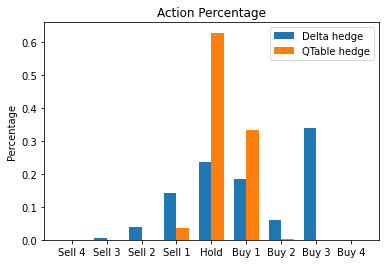

In [ ]:
labels = ['Sell 4', 'Sell 3', 'Sell 2', 'Sell 1', 'Hold', 'Buy 1', 'Buy 2', 'Buy 3', 'Buy 4']
delta_hedge_actions = delta_hedge_status[['sell-4','sell-3','sell-2','sell-1','hold', 'buy-1','buy-2','buy-3','buy-4']].iloc[-1]
qtable_hedge_actions = train_progress[['sell-4','sell-3','sell-2','sell-1','hold', 'buy-1','buy-2','buy-3','buy-4']].iloc[-1]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
deltah = ax.bar(x - width/2, delta_hedge_actions, width, label='Delta hedge')
qtableh = ax.bar(x + width/2, qtable_hedge_actions, width, label='QTable hedge')

ax.set_ylabel('Percentage')
ax.set_title('Action Percentage')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()
plt.savefig(f'{model_path}action.png')
plt.show()

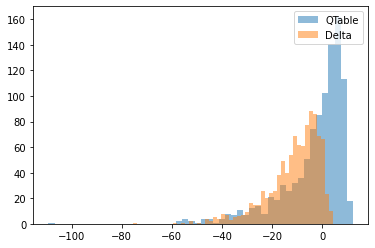

In [ ]:
qtable_pnl_list = qtable_bot._predictor.get_pred_pnls()
delta_pnl_list = delta_bot._predictor.get_pred_pnls()
plt.hist(qtable_pnl_list, bins=50, alpha=0.5, label='QTable')
plt.hist(delta_pnl_list, bins=50, alpha=0.5, label='Delta')
plt.legend(loc='upper right')
plt.savefig(f'{model_path}dist.png')
plt.show()

In [ ]:
import shutil 
shutil.copyfile(pred_logger.file_path,f"{model_path}qtable_log.csv")
shutil.copyfile(delta_pred_logger.file_path,f"{model_path}delta_log.csv")

# Results

In the following setups, P&L $\kappa=0.08$.

  1. Trading cost = 0; Call option holding = -10 shares; Initial stock holding = 5 shares
  
   <img src="https://drive.google.com/thumbnail?id=1-O_6O5j4joKMvdHaeWsDhMN7hDQ0oOil" width="500" height="200">



Step by Step Demo of QTable Bot Construction

In [ ]:
#@title Reset Environment
environment.set_obs_attr(qtable_bot_env_attr)
spec = specs.make_environment_spec(environment)

In [ ]:
#@title Build Replay Buffer
replay_table_name = 'replay_table'
replay_table = reverb.Table(
      name=replay_table_name,
      sampler=reverb.selectors.Uniform(),
      remover=reverb.selectors.Fifo(),
      max_size=1,
      rate_limiter=reverb.rate_limiters.MinSize(1),
      signature=adders.NStepTransitionAdder.signature(spec))
server = reverb.Server([replay_table], port=None)
address = f'localhost:{server.port}'
adder = adders.NStepTransitionAdder(
        priority_fns={replay_table_name: lambda x: 1.},
        client=reverb.Client(address),
        n_step=1,
        discount=1.0)
dataset = datasets.make_reverb_dataset(
            table=replay_table_name,
            client=reverb.TFClient(address),
            batch_size=1,
            prefetch_size=None,
            environment_spec=spec,
            transition_adder=True)

dat_iterator = iter(dataset) 

In [ ]:
#@title Create Actor and Learner
step_qtable = QTable(observation_spec=spec.observations, 
                action_spec=spec.actions)
actor = QTableActor(qtable=step_qtable, 
                    epsilon=0.2, 
                    adder=adder)
learner = QTableLearner(qtable=step_qtable, 
                        learning_rate=1e-3, 
                        target_update_period=1, 
                        dataset=dataset)

In [ ]:
#@title Training Loop
num_episodes = 100 #@param {type:"integer"}

actor_steps_taken = 0
learner_steps_taken = 0

for episode in range(num_episodes):
  # actor._adder.reset()
  timestep = environment.reset()
  actor.observe_first(timestep)
  episode_return = 0

  while not timestep.last():
    #learner Get an action from the agent and step in the environment.
    action = actor.select_action(timestep.observation)
    next_timestep = environment.step(action)

    # Record the transition.
    actor.observe(action=action, next_timestep=next_timestep)

    # Book-keeping.
    episode_return += next_timestep.reward
    actor_steps_taken += 1
    learner_steps_taken += 1
    timestep = next_timestep
    learner.step()

  # Log quantities.
  print('Episode: %d | Return: %f | Learner steps: %d | Actor steps: %d'%(
      episode, episode_return, learner_steps_taken, actor_steps_taken))

[Learner] Avg Td Error = -1.914 | Steps = 1 | Walltime = 0
Episode: 0 | Return: -8.049007 | Learner steps: 3 | Actor steps: 3
Episode: 1 | Return: -17.178998 | Learner steps: 6 | Actor steps: 6
Episode: 2 | Return: -1.903435 | Learner steps: 9 | Actor steps: 9
Episode: 3 | Return: -0.645727 | Learner steps: 12 | Actor steps: 12
Episode: 4 | Return: -9.332153 | Learner steps: 15 | Actor steps: 15
Episode: 5 | Return: 2.242455 | Learner steps: 18 | Actor steps: 18
Episode: 6 | Return: -17.981263 | Learner steps: 21 | Actor steps: 21
Episode: 7 | Return: -1.023621 | Learner steps: 24 | Actor steps: 24
Episode: 8 | Return: -7.353714 | Learner steps: 27 | Actor steps: 27
Episode: 9 | Return: -7.473374 | Learner steps: 30 | Actor steps: 30
Episode: 10 | Return: -11.820989 | Learner steps: 33 | Actor steps: 33
Episode: 11 | Return: -3.591912 | Learner steps: 36 | Actor steps: 36
Episode: 12 | Return: -14.469015 | Learner steps: 39 | Actor steps: 39
Episode: 13 | Return: 0.381621 | Learner ste

Dive into Learner step

In [ ]:
#@title First step
actor._adder.reset()
timestep = environment.reset()
actor.observe_first(timestep)
print(timestep.observation)

[455.   0.  50.]


In [ ]:
#@title Mid Actor step
action = actor.select_action(timestep.observation)
next_timestep = environment.step(action)

# Record the transition.
actor.observe(action=action, next_timestep=next_timestep)
print(action)
print(next_timestep.observation)

[2.]
[365.        9.       52.36527]


In [ ]:
#@title Learning Step
learning_rate = 0.001 #@param {type:"number"}
inputs = next(dat_iterator)
o_tm1, a_tm1, r_t, d_t, o_t = inputs.data
avg_td_error = 0.
o_tm1_i = o_tm1[0]
a_tm1_i = a_tm1[0]
r_t_i = r_t[0]
d_t_i = d_t[0]
o_t_i = o_t[0]
cur_q = step_qtable.getQ(o_tm1_i.numpy(), a_tm1_i.numpy())
# bellman eq
target_q = r_t_i + d_t_i * \
    step_qtable.select_maxQ(o_t_i.numpy())
td_error = target_q - cur_q
avg_td_error += td_error
inc = learning_rate * td_error
print(f"action = {a_tm1_i.numpy()[0]}; \nobservation = {o_tm1_i.numpy()}; \ncur_Q = {cur_q}; \ntarget_Q = {target_q}; \ninc = {inc}")
# update qtable
step_qtable.update(o_tm1_i.numpy(), a_tm1_i.numpy(), inc)
avg_td_error = avg_td_error/o_tm1.shape[0]

action = 3.0; 
observation = [455.   0.  50.]; 
cur_Q = 0.2827048897743225; 
target_Q = -1.0892881155014038; 
inc = -0.0013719931012019515
